In [2]:
# implementing bayesian statistics on dataset phd-delays.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import sklearn as sk
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# reading the dataset
df = pd.read_csv('phd-delays.csv', delimiter=';')
df.columns = ['B3_difference_extra','E4_having_child','E21_sex','E22_Age','E22_Age_Squared']

def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

standardize(df['B3_difference_extra'])
standardize(df['E22_Age'])
standardize(df['E22_Age_Squared'])
#split the dataset
X = df[['E22_Age','E22_Age_Squared']]
y = df['B3_difference_extra']
import sklearn.model_selection as skm
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:

# creating a model for y = b_intercept + b_0*age + b_1*age^2 + e
mu_ = 0
sd = 100
with pm.Model() as model:
    # mu_ = pm.Uniform('mean_gen' , lower = -10, upper = 20)
    b_intercept = pm.Normal('b_intercept',mu = mu_, sigma=sd)
    b_0 = pm.Normal('b_0' , mu = mu_ , sigma=sd)
    b_1 = pm.Normal('b_1' , mu = mu_, sigma = sd)

    sg = pm.HalfNormal('sg' , sigma=1)
    likelihood = pm.Normal('y', mu=b_intercept + b_0*X_train['E22_Age'] + b_1*X_train['E22_Age_Squared'], sigma=sg, observed=y_train)

    # perform inference
    trace = pm.sample(10000,init='adapt_diag',tune = 2000, target_accept = 0.95)
    # prior_checks = pm.sample_prior_predictive(samples = 300)



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sg, b_1, b_0, b_intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.


Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_intercept,-40.445,10.881,-61.203,-20.247,0.374,0.264,841.0,1098.0,1.01
b_0,2.356,0.512,1.384,3.290,0.018,0.013,834.0,1040.0,1.01
b_1,-0.023,0.005,-0.032,-0.013,0.000,0.000,853.0,1066.0,1.01
sg,11.447,0.343,10.787,12.070,0.009,0.006,1582.0,1519.0,1.00


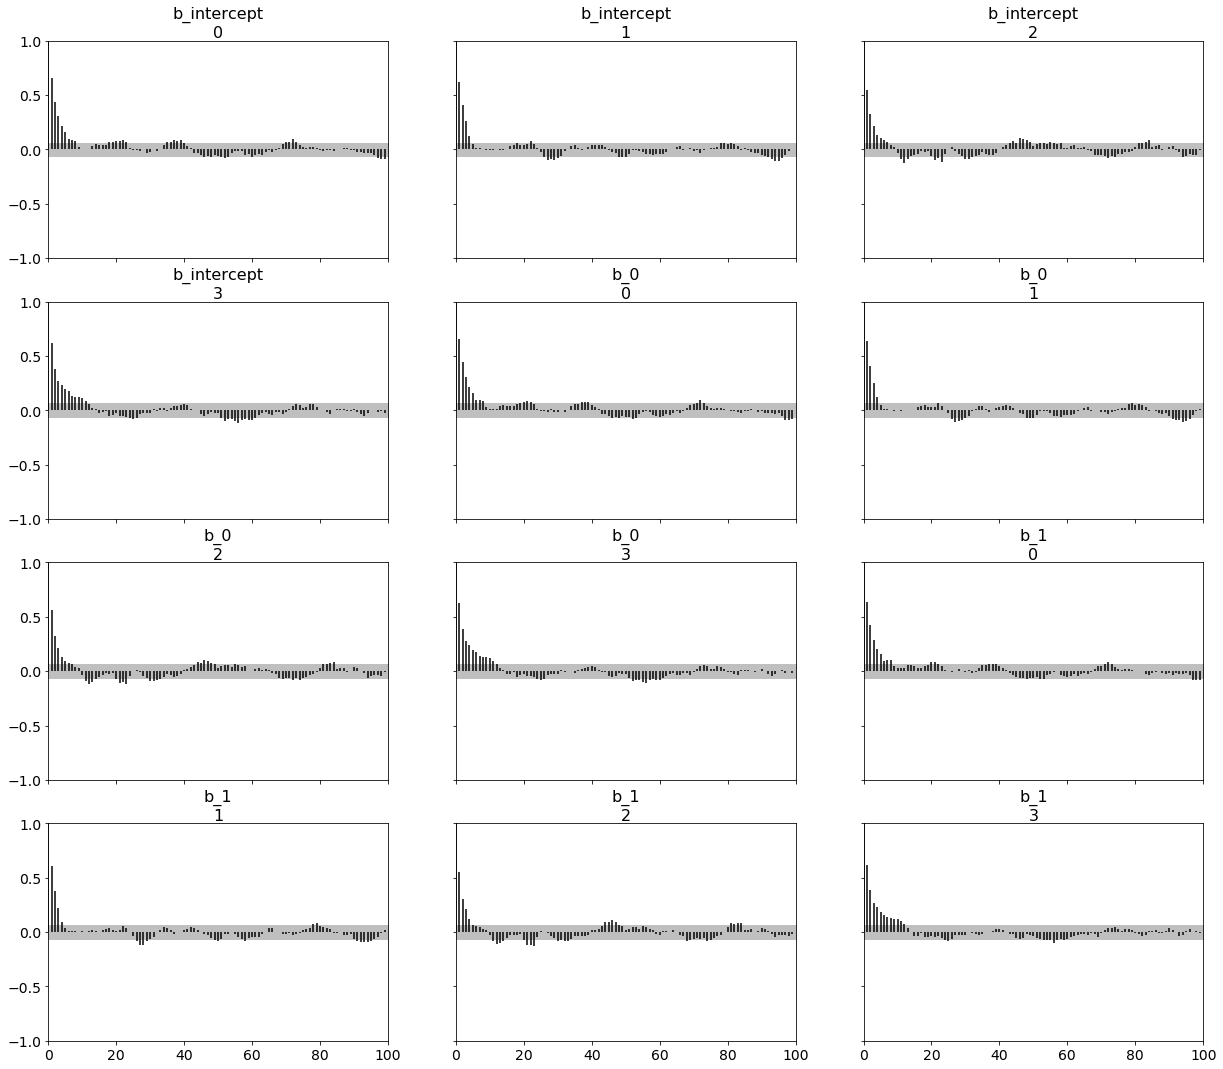

In [28]:
pm.autocorrplot(trace, var_names=['b_intercept','b_0','b_1'])

# perform prior predictive checks on the model
with model:
    prior_checks = pm.sample_prior_predictive(samples = 300)
    posterior_checks = pm.sample_posterior_predictive(trace, samples =300)

az.summary(trace)
# compare posterior predictive with observed data
# y_pred = trace[:2000].get_values('y')

# histo of the posterior predictive
# plt.hist(posterior_checks['y'].flatten(), bins=50, density=True, alpha=0.5, label='posterior predictive checks')
# plt.hist(y_train, bins=50, density=True, alpha=0.5, label='observed data')
# plt.legend(loc=0)
# plt.show()

In [13]:
# performing bayes factor analysis
with model:
    # compute the bayes factor for the model
    bf = pm.compare({'model':trace}, ic='WAIC')
    print(bf)

    

ValueError: unexpected array size: new_size=1, got array with arr_size=0


In [21]:
# finding MAP parameter values for the model
map_estimate = pm.find_MAP(model=model)
map_estimate

# perform accuracy test on this test data with MAP parameter values

y_pred = map_estimate['b_intercept'] + map_estimate['b_0']*X_test['E22_Age'] + map_estimate['b_1']*X_test['E22_Age_Squared']
print(y_pred)
print(y_test)
print(sk.metrics.mean_squared_error(y_test, y_pred))



25     11.581685
317     9.569056
73     10.875513
193    10.259364
57     10.037501
         ...    
258    10.472987
3      11.417502
77     10.472987
240     9.807399
60     10.037501
Length: 67, dtype: float64
25     17
317     0
73     22
193     0
57      0
       ..
258     0
3      17
77     21
240     3
60     -2
Name: B3_difference_extra, Length: 67, dtype: int64
199.88086423600078


In [ ]:
# plot r_hat for all parameters
az.plot_kde(y)
plt.show()
# plots of the trace runs performed
az.plot_trace(trace)
plt.show()
az.plot_posterior(trace)
plt.show()
# az.plot_density(trace)
# plt.show()
# perform accuracy test on this test dataset
az.summary(trace) #summarise our trace run with MCMC

In [ ]:
with model:
    ppc = az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(trace))

posterior_samples = ppc.posterior_predictive['y'].values.flatten()
plt.hist(posterior_samples, bins=50, density=True, alpha=0.5)
plt.show()